# Computer Vision

## 🚦🚥 Traffic Monitoring System using Essebmle Machine Learning

   👩‍💻 Name: Byamugisha Africano
   🧰Registration No:* 2023/HD05/04595/U
   📅Date: June 05, 2024

## 🎯Objectives

To develop a traffic monitoring system using traditional essebmle  machine learning techniques. To detect motorcycles and trucks in a video feed.
To Create a dataset from a videdeo feed to traing models
To esseble the best 3 models and evaluation made.

The following Traditional Machine Learning Models were trained :- 

- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)
- Decision Trees
- Random Forest

## 🛠️Implementation Below:- 

## Import necessary libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import os

import warnings
warnings.filterwarnings("ignore")


## Annotating and Pre-processing Images

The Video was convert to frames with an FPS of 30 using the script as explained [HERE](traffic_monitoring_system\data\01_generate_images_from_video.md)

Manual annotation was done using two tools
1.  LabelImg package as detailed [HERE](traffic_monitoring_system\data\02_setting_up_labelImg.md), which was limiting and the remaining were done using ->
2. Computer Vision Annotation Tool (CVAT) online open source tool, accessed [HERE](https://app.cvat.ai/). 

The data was exported as a CSV file with columns of filename, x_min, y_min, x_max, y_max, and class (truck, motorcycle and other vehicles) as shown in image below
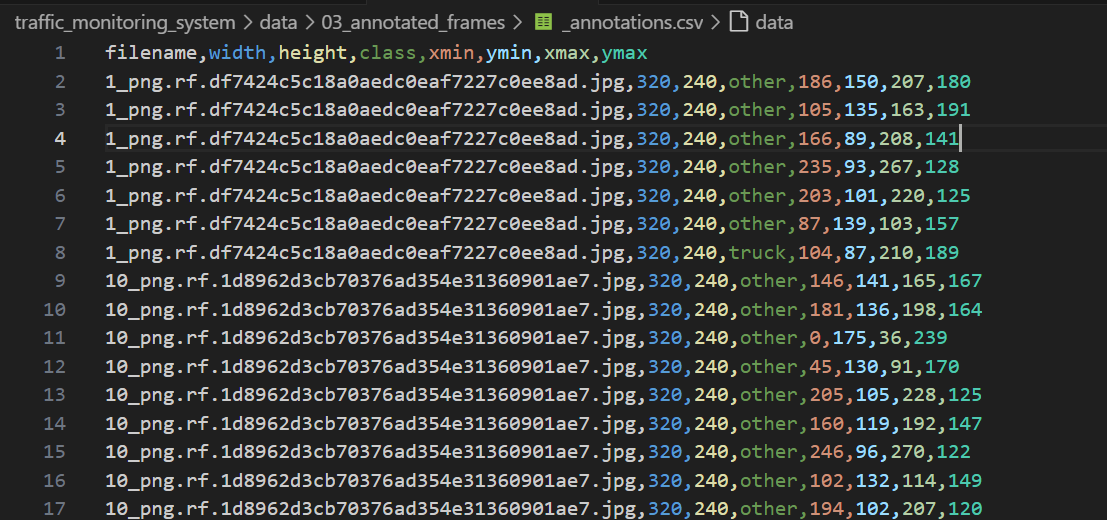

## Loading Annotations

In [82]:
def load_annotations(annotation_path):
    annotations = pd.read_csv(annotation_path)
    return annotations

annotations_path = r'D:\PRSN\Computer_Vision_Cwks\traffic_monitoring_system\data\03_annotated_frames\annotations.csv'  # Replace with actual path

annotations = load_annotations(annotations_path)

In [88]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189 entries, 0 to 1188
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1189 non-null   object
 1   width     1189 non-null   int64 
 2   height    1189 non-null   int64 
 3   class     1189 non-null   object
 4   xmin      1189 non-null   int64 
 5   ymin      1189 non-null   int64 
 6   xmax      1189 non-null   int64 
 7   ymax      1189 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 74.4+ KB


In [89]:
annotations.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1_png.rf.df7424c5c18a0aedc0eaf7227c0ee8ad.jpg,320,240,other,186,150,207,180
1,1_png.rf.df7424c5c18a0aedc0eaf7227c0ee8ad.jpg,320,240,other,105,135,163,191
2,1_png.rf.df7424c5c18a0aedc0eaf7227c0ee8ad.jpg,320,240,other,166,89,208,141
3,1_png.rf.df7424c5c18a0aedc0eaf7227c0ee8ad.jpg,320,240,other,235,93,267,128
4,1_png.rf.df7424c5c18a0aedc0eaf7227c0ee8ad.jpg,320,240,other,203,101,220,125
5,1_png.rf.df7424c5c18a0aedc0eaf7227c0ee8ad.jpg,320,240,other,87,139,103,157
6,1_png.rf.df7424c5c18a0aedc0eaf7227c0ee8ad.jpg,320,240,truck,104,87,210,189
7,10_png.rf.1d8962d3cb70376ad354e31360901ae7.jpg,320,240,other,146,141,165,167
8,10_png.rf.1d8962d3cb70376ad354e31360901ae7.jpg,320,240,other,181,136,198,164
9,10_png.rf.1d8962d3cb70376ad354e31360901ae7.jpg,320,240,other,0,175,36,239


## Count the occurrences of each class

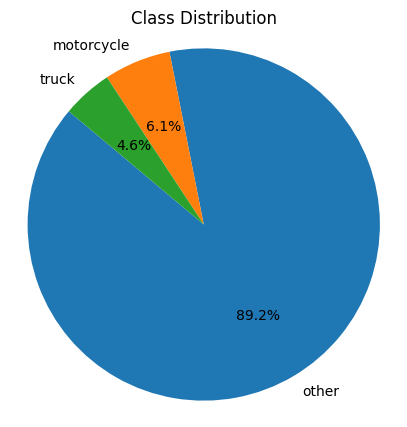

In [93]:
class_counts = annotations['class'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')

plt.show()

## Feature Extraction

In [94]:
def extract_features(image, bbox):
    x_min, y_min, x_max, y_max = bbox
    cropped_image = image[y_min:y_max, x_min:x_max]
    resized_image = cv2.resize(cropped_image, (64, 64))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    
    # Extract histogram
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256]).flatten()
    
    # Extract edges using Canny
    edges = cv2.Canny(gray_image, 100, 200).flatten()
    
    # Combine features
    features = np.hstack((hist, edges))
    return features

## Preparing the Dataset

In [95]:
def prepare_dataset(annotations, frame_dir):
    data = []
    labels = []
    
    for _, row in annotations.iterrows():
        filename = row['filename']
        img_path = os.path.join(frame_dir, filename)
        image = cv2.imread(img_path)
        if image is None:
            continue
        bbox = (row['xmin'], row['ymin'], row['xmax'], row['ymax'])
        features = extract_features(image, bbox)
        data.append(features)
        labels.append(row['class'])
    
    return np.array(data), np.array(labels)

frame_dir = r'D:\PRSN\Computer_Vision_Cwks\traffic_monitoring_system\data\03_annotated_frames'

data, labels = prepare_dataset(annotations, frame_dir)


## Training the Machine Learning Models

In [96]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

knn = KNeighborsClassifier()
svm = SVC(probability=True)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

models = [knn, svm, dt, rf]
model_names = ['KNN', 'SVM', 'Decision Tree', 'Random Forest']

for model in models:
    model.fit(X_train, y_train)

In [167]:
knn

KNeighborsClassifier()

In [168]:
svm

SVC(probability=True)

In [169]:
dt

DecisionTreeClassifier()

In [170]:
rf

RandomForestClassifier()

## Evaluation Results

In [104]:
## function to print evaluation results

def evaluate_and_plot_model(model, model_name, X_test, y_test):

    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
        if y_proba.ndim == 1:
            y_proba = y_proba.reshape(-1, 1)
    else:
        y_proba = model.decision_function(X_test)

    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    precision = precision_score(y_test, y_pred, average='weighted', zero_division='warn')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    print(f'AUC: {round(auc, 3)}\nPrecision: {round(precision, 3)}\nRecall: {round(recall, 3)}\nF1 Score: {round(f1, 3)}\n')


### For KNN model evaluation

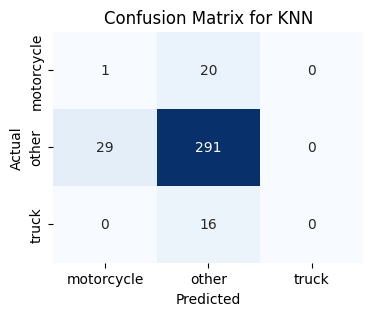

AUC: 0.469
Precision: 0.8
Recall: 0.818
F1 Score: 0.809



In [105]:
name = 'KNN'
model = knn
evaluate_and_plot_model(model, name, X_test, y_test)

### For SVM model evaluation

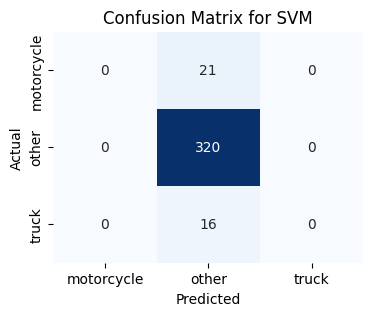

AUC: 0.922
Precision: 0.803
Recall: 0.896
F1 Score: 0.847



In [107]:
name = 'SVM'
model = svm
evaluate_and_plot_model(model, name, X_test, y_test)

### For Decision Tree model evaluation:

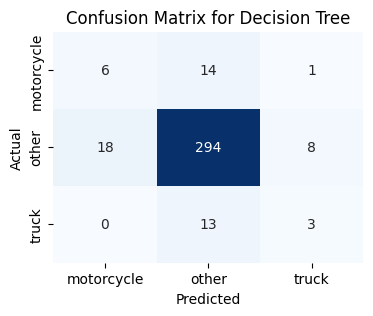

AUC: 0.597
Precision: 0.847
Recall: 0.849
F1 Score: 0.848



In [110]:
name = 'Decision Tree'
model = dt
evaluate_and_plot_model(model, name, X_test, y_test)

### For Random Forest model evaluation

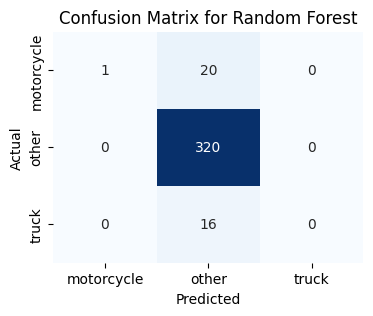

AUC: 0.883
Precision: 0.865
Recall: 0.899
F1 Score: 0.854



In [112]:
name = 'Random Forest'
model = rf
evaluate_and_plot_model(model, name, X_test, y_test)

## Comparing all the models all together

In [114]:
model_names = ['KNN', 'SVM', 'Decision Tree', 'Random Forest']
auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for model, name in zip([knn, svm, dt, rf], model_names):
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
        if y_proba.ndim == 1:
            y_proba = y_proba.reshape(-1, 1)
    else:
        y_proba = model.decision_function(X_test)

    auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    precision = precision_score(y_test, y_pred, average='weighted', zero_division='warn')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

metrics_df = pd.DataFrame({
    'Model': model_names,
    'AUC': auc_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

metrics_df_sorted = metrics_df.sort_values(by='F1 Score', ascending=False)

print("Metrics for Different Models :\n")
metrics_df_sorted

Metrics for Different Models :



,Model,AUC,Precision,Recall,F1 Score
3,Random Forest,0.883361,0.864539,0.899160,0.853971
2,Decision Tree,0.597045,0.846874,0.848739,0.847535
1,SVM,0.921821,0.803459,0.896359,0.847370
0,KNN,0.468618,0.799638,0.817927,0.808614


## The confusion Matrices for all teh models

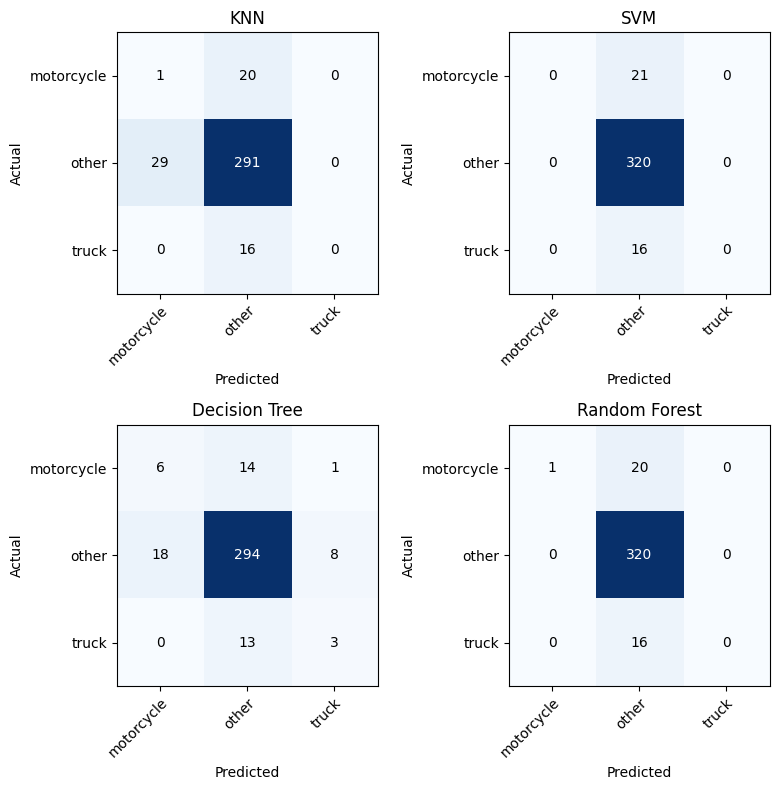

In [116]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, (model, name) in enumerate(zip([knn, svm, dt, rf], model_names)):
    ax = axs[i//2, i%2]
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=model.classes_, yticklabels=model.classes_,
           title=f'{name}',
           xlabel='Predicted',
           ylabel='Actual')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()

## Building Ensemble Model
Using the the best three performing models based on F1 score

In [140]:
best_models = sorted(evaluation_results, key=lambda x: x[5], reverse=True)[:3]
best_model_names = [model[0] for model in best_models]

ensemble_model = VotingClassifier(
    estimators=[(name.lower(), models[model_names.index(name)]) for name in best_model_names], 
    voting='soft'
)

ensemble_model.fit(X_train, y_train)

y_pred_ensemble = ensemble_model.predict(X_test)
y_proba_ensemble = ensemble_model.predict_proba(X_test)

cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble, average='weighted')
recall_ensemble = recall_score(y_test, y_pred_ensemble, average='weighted')
f1_ensemble = f1_score(y_test, y_pred_ensemble, average='weighted')


In [141]:
ensemble_model

VotingClassifier(estimators=[('decision tree', DecisionTreeClassifier()),
                             ('random forest', RandomForestClassifier()),
                             ('svm', SVC(probability=True))],
                 voting='soft')

## Evaluating the Ensemble Model

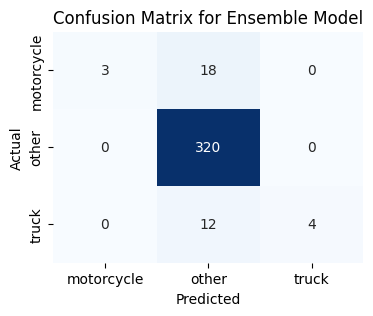

AUC: 0.898
Precision: 0.923
Recall: 0.916
F1 Score: 0.889



In [139]:
name = "Ensemble Model"
model = ensemble_model

evaluate_and_plot_model(ensemble_model, "Ensemble Model", X_test, y_test)

In [155]:
results = pd.DataFrame(
    [(name, auc, precision, recall, f1) for name, _, auc, precision, recall, f1 in evaluation_results] +
    [('Ensemble', auc_ensemble, precision_ensemble, recall_ensemble, f1_ensemble)],
    columns=['Model', 'AUC', 'Precision', 'Recall', 'F1 Score']
)

results_sorted = results.sort_values(by='F1 Score', ascending=False)

results_sorted

,Model,AUC,Precision,Recall,F1 Score
4,Ensemble,NaN,0.888181,0.907563,0.880284
2,Decision Tree,0.650738,0.866019,0.857143,0.860720
3,Random Forest,0.894553,0.864539,0.899160,0.853971
1,SVM,0.920508,0.803459,0.896359,0.847370
0,KNN,0.468618,0.799638,0.817927,0.808614


## Confusion Matrix For all inclusing the essemble model

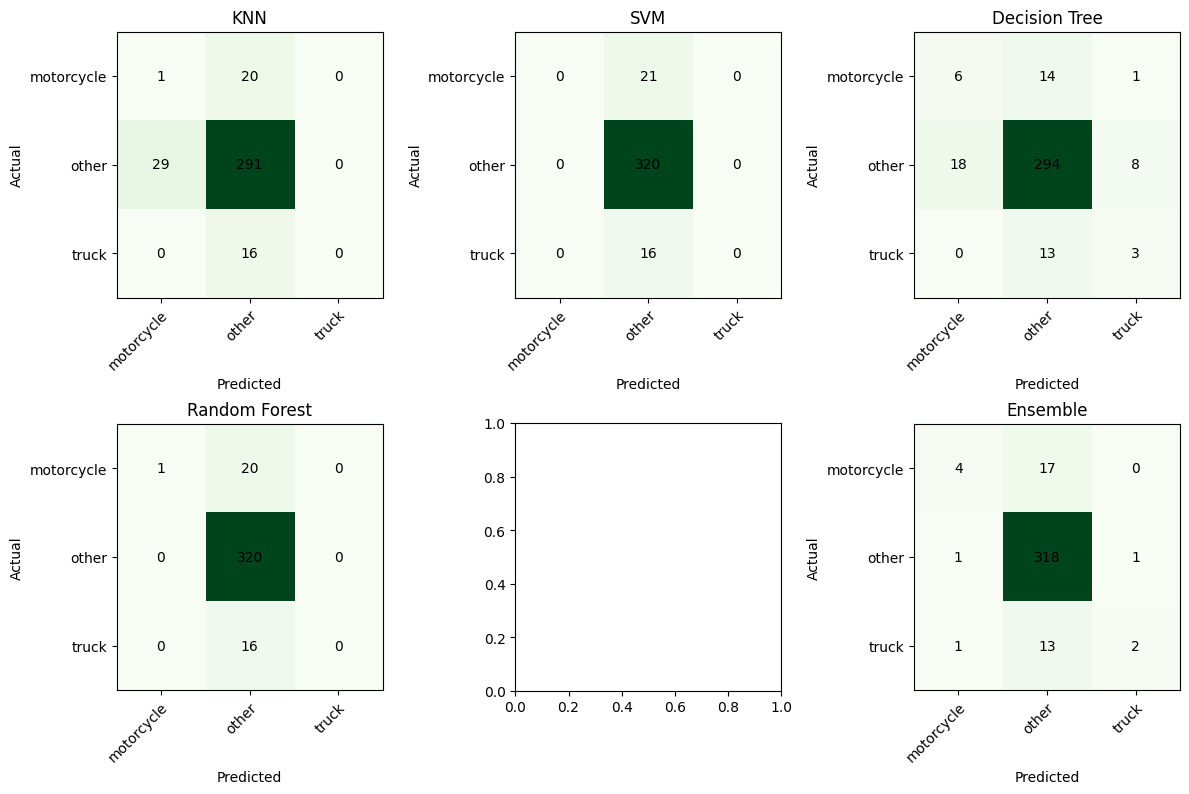

In [166]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, (model, name) in enumerate(zip([knn, svm, dt, rf], model_names)):
    ax = axs[i//3, i%3]
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=model.classes_, yticklabels=model.classes_,
           title=f'{name}',
           xlabel='Predicted',
           ylabel='Actual')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="black")

ax = axs[1, 2]
im = ax.imshow(cm_ensemble, interpolation='nearest', cmap=plt.cm.Greens)
ax.set(xticks=np.arange(cm_ensemble.shape[1]),
       yticks=np.arange(cm_ensemble.shape[0]),
       xticklabels=model.classes_, yticklabels=model.classes_,
       title='Ensemble',
       xlabel='Predicted',
       ylabel='Actual')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(cm_ensemble.shape[0]):
    for j in range(cm_ensemble.shape[1]):
        ax.text(j, i, format(cm_ensemble[i, j], 'd'),
                ha="center", va="center",
                color="black")

plt.tight_layout()
plt.show()